# CLIP

In [26]:
import torch
import torch.nn as nn
import numpy as np
import torch.functional as F
import tqdm

from torchvision import models
from tqdm import tqdm

In [27]:
import pandas as pd

df = pd.read_csv('data/myntradataset/styles.csv', on_bad_lines='skip')
df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [28]:
nan_values = df[df['productDisplayName'].isnull()].index
nan_values

Index([3677, 14291, 17639, 22089, 23484, 37531, 40675], dtype='int64')

In [29]:
# Drop rows with missing values in productDisplayName
df = df.dropna(subset=['productDisplayName'])

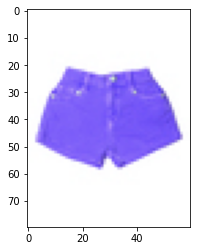

In [30]:
import os
import cv2
import matplotlib.pyplot as plt

images = []

for img in os.listdir('data/myntradataset/images/'):
    if img.endswith('.jpg'):
        if df[df['id'] == img.split('.')[0]].empty and img.split('.')[0] not in nan_values:
            images.append(cv2.imread('data/myntradataset/images/' + img))

idx = np.random.randint(0, len(images))
plt.imshow(images[idx])

In [31]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")  # Example tokenizer
def preprocess_text(text):
    return tokenizer(text, return_tensors="pt", padding=True, truncation=True)

In [58]:
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

class FashionDataset(Dataset):
    def __init__(self, csv_file, root_dir, train=True, transform=None):
        self.data = pd.read_csv(csv_file, on_bad_lines='skip')
        self.root_dir = root_dir
        self.transform = transform
        self.train = train

        train_data, test_data = train_test_split(self.data, test_size=0.2, random_state=42)
        self.data = train_data if self.train else test_data

        self.labels = preprocess_text(self.data['productDisplayName'].astype(str).values.tolist())['input_ids']

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, str(self.data.iloc[idx, 0]) + ".jpg")
        image = cv2.imread(img_name)
        image = cv2.resize(image, (224, 224))
        image = image.reshape(3, 224, 224)
        image = torch.tensor(image, dtype=torch.float32)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [65]:

from torchvision import transforms


transform = transforms.Compose([
])

train_dataset = DataLoader(FashionDataset('data/myntradataset/styles.csv', 'data/myntradataset/images/', train=True, transform=transform), batch_size=32, shuffle=True)
test_dataset = DataLoader(FashionDataset('data/myntradataset/styles.csv', 'data/myntradataset/images/', train=False, transform=transform), batch_size=32, shuffle=True)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 1111
Test dataset size: 278


In [66]:
class TextEncoder(nn.Module):
    def __init__(self):
        super(TextEncoder, self).__init__()
        self.transformer = AutoModel.from_pretrained("bert-base-uncased")
        self.fc = nn.Linear(768, 512)  # BERT outputs 768-dim embeddings

    def forward(self, input_ids, attention_mask):
        output = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        return self.fc(output.pooler_output)



In [67]:
class ImageEncoder(nn.Module):
    def __init__(self):
        super(ImageEncoder, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, 512)

    def forward(self, x):
        return self.model(x)


In [68]:
def contrastive_loss(image_embeddings, text_embeddings, temperature=0.07):
    image_embeddings = nn.functional.normalize(image_embeddings, dim=1)
    text_embeddings = nn.functional.normalize(text_embeddings, dim=1)
    logits = torch.mm(image_embeddings, text_embeddings.t()) / temperature
    labels = torch.arange(len(image_embeddings)).to(image_embeddings.device)
    return nn.CrossEntropyLoss()(logits, labels) + nn.CrossEntropyLoss()(logits.t(), labels)

In [71]:
def train(text_encoder, image_encoder, dataloader, optimizer, device, epochs):
    for epoch in range(epochs):
        text_encoder.train()
        image_encoder.train()
        total_loss = 0
        for images, input_ids in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
            attention_mask = torch.ones_like(input_ids)
            images = images.to(device)
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            optimizer.zero_grad()
            text_embeddings = text_encoder(input_ids, attention_mask)
            image_embeddings = image_encoder(images)
            loss = contrastive_loss(image_embeddings, text_embeddings)

            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss/len(dataloader)}")

# def train(image_encoder, text_encoder, criterion, optimizer, data_loader, num_epochs, device):
#     for epoch in range(num_epochs):
#         image_encoder.train()
#         text_encoder.train()
#         epoch_loss = 0

#         for i, (images, texts) in enumerate(tqdm(data_loader, desc=f"Epoch {epoch + 1}/{num_epochs}")):
#             images = images.to(device)
#             texts = texts.to(device)

#             optimizer.zero_grad()

#             image_features = image_encoder(images)
#             text_features = text_encoder(texts.to(torch.float32))
#             print(image_features.shape, text_features.shape)
#             print(image_features, text_features)

#             loss_positive_images = criterion(image_features.to(torch.float32), text_features)
#             loss_positive_digits = criterion(text_features, image_features)

#             loss = (loss_positive_images + loss_positive_digits) / 2

#             loss.backward()
#             optimizer.step()

#             epoch_loss += loss.item()

#         avg_loss = epoch_loss / len(data_loader)
#         print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")

In [72]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
image_model = ImageEncoder().to(device)
text_model = TextEncoder().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(list(image_model.parameters()) + list(text_model.parameters()), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


train(text_model, image_model, train_dataset, optimizer, device, 1)

/home/raphael/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/raphael/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/1:   0%|          | 4/1111 [00:34<2:37:14,  8.52s/it]


KeyboardInterrupt: 